# Worst case probabilities

Shift of worst case probabilities for varying $\omega$ in state 0.

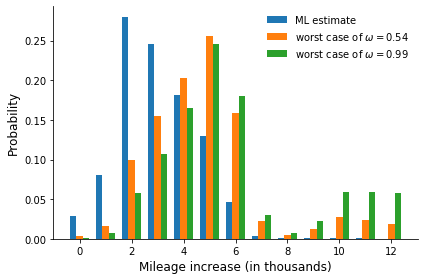

In [72]:
get_probability_shift()

The following figure shows a stylized example for the demonstration of the shift of the replacement probability curve. For the construction of the uncertainty set, the mean number of observation 4292/78 was used. The transition probabilities are estimated from Rust's paper with discreteziation 1000 miles. The cost parameters are (10, 10), which are in contrast to the ones estimated by Rust (10, 2.27).

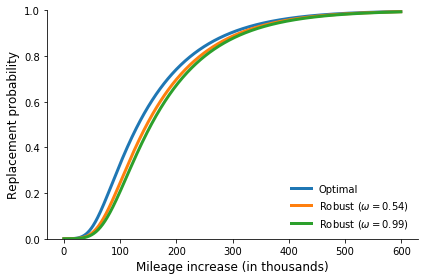

In [73]:
get_replacement_probabilities_stylized()

The following figure shows the average state of replacement observed in simulated data. The means are rounded due to standard rounding rules. The underlying transition matrix governing the stochastic process of the milage increase is the ML estimate of Rust paper with discretization of 1000 miles. The mapping for the robust strategies from $\omega$ to $\rho$ is done with the mean number of observations 4292/389. The cost parameters are (10, 10).

## Should we vary training sample and show effect?

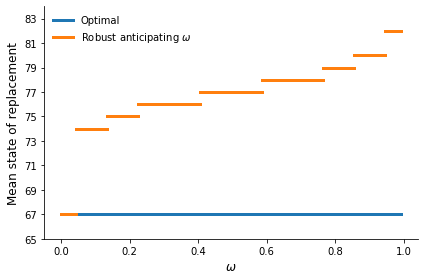

In [74]:
get_replacement_thresholds()

The following figure shows the performance of the nominal strategy, when the worst case transition matrix of ω=0.99 is underlying. The cost and transition parameters are from the 5000 miles discretization. The two benchmarks are the expected value of an optimal strategy, when the underlying transition matrix is the ML estimate or the worst case transition matrix for omega=0.99. The number of observations for the mapping between ρ and ω is again the mean 4292/78.

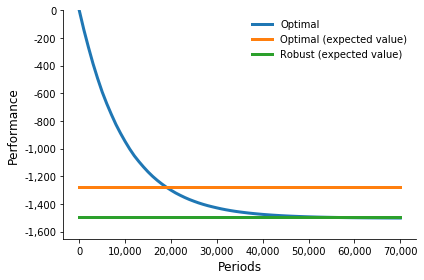

In [75]:
get_performance_decision_rules()

# Performance plot

The following figure show the current value of different strategies given the worst case transition matrix according to the $\omega$ on the x-axis. The performance is averaged over 200 buses and each bus drives over a 70000 periods. The cost parameters are again (10, 10) and the ML estimate is from group 4 with a discretization of 1000 miles. The nominal is the strategy where the agent has the ML estimate as his belief. The optimal corresponds to a robust with the exact omega, i.e. the agent has an unbiased beleif of the true underlying transition matrix

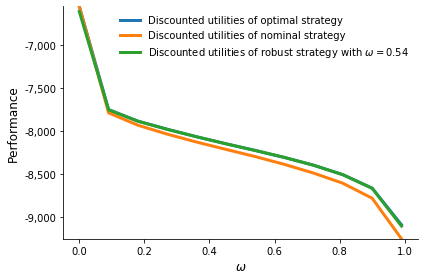

In [77]:
get_performance()